# creative deep learning final project 
graphSGAN

Semi-supervised Learning on Graphs with Generative

How to display log?

1.Open anaconda cmd Prompt.

2.Type: tensorboard --logdir <full path to log directory>.
    
3.Press Enter.
    
4.Copy the URL from the cmd (should be http://localhost:6006/) and load it in web browser. 

# imports

In [1]:
from __future__ import print_function 
import torch
import sys
import import_ipynb
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from functional import log_sum_exp, pull_away_term
from torch.utils.data import DataLoader,TensorDataset

from torch.nn.parameter import Parameter
import argparse
from Nets import Generator, Discriminator
import tensorboardX
import os
import random
from FeatureGraphDataset import FeatureGraphDataset
import pickle 
import matplotlib.pyplot as plt

from torchsummary import summary
from sklearn.manifold import TSNE
from moviepy.editor import ImageSequenceClip
from IPython.display import Image

importing Jupyter notebook from functional.ipynb
importing Jupyter notebook from Nets.ipynb
importing Jupyter notebook from FeatureGraphDataset.ipynb


# visualization

In [2]:
def plt2arr(fig):
    rgb_str = fig.canvas.tostring_rgb()
    (w,h) = fig.canvas.get_width_height()
    rgba_arr = np.fromstring(rgb_str, dtype=np.uint8, sep='').reshape((w,h,-1))
    return rgba_arr


def visualize(h, color, epoch):
    fig = plt.figure(figsize=(8,8), frameon=False)
    fig.suptitle(f'Epoch = {epoch}')
    # Fit TSNE with 2 components
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())
    plt.xticks([])
    plt.yticks([])
    plt.scatter(z[:, 0], 
                z[:, 1], 
                s=10, 
                c=color.detach().cpu().numpy(), 
                cmap="Set3")
    fig.canvas.draw()

    # Convert to numpy
    return plt2arr(fig)


# graphSGAN

In [3]:
class GraphSGAN(object):
    def __init__(self, G, D, dataset, args):
        self.images = []
        if os.path.exists(args.savedir):
            print('Loading model from ' + args.savedir)
            self.G = torch.load(os.path.join(args.savedir, 'G.pkl'))
            self.D = torch.load(os.path.join(args.savedir, 'D.pkl'))
            self.embedding_layer = torch.load(os.path.join(args.savedir, 'embedding.pkl'))
        else:
            os.makedirs(args.savedir)
            self.G = G
            self.D = D
            self.embedding_layer = nn.Embedding(dataset.n, dataset.d)
            self.embedding_layer.weight = Parameter(torch.Tensor(dataset.embbedings))
            torch.save(self.G, os.path.join(args.savedir, 'G.pkl'))
            torch.save(self.D, os.path.join(args.savedir, 'D.pkl'))
            torch.save(self.embedding_layer, os.path.join(args.savedir, 'embedding.pkl'))
        self.writer = tensorboardX.SummaryWriter(log_dir=args.logdir)
        if args.cuda:
            self.G.cuda()
            self.D.cuda() # self.embedding_layer is on CPU
        self.dataset = dataset
        self.Doptim = optim.Adam(self.D.parameters(), lr=args.lr, betas= (args.momentum, 0.999))
        self.Goptim = optim.Adam(self.G.parameters(), lr=args.lr, betas = (args.momentum,0.999))
        self.args = args
        print("-----Discriminator Summary-----")
        summary(self.D)
        print("-------Generator Summary-------")
        summary(self.G)
        print("-------Learning process--------")

    def trainD(self, idf_label, y, idf_unlabel):
        x_label, x_unlabel, y = self.make_input(*idf_label), self.make_input(*idf_unlabel), Variable(y, requires_grad = False)
        if self.args.cuda:
            x_label, x_unlabel, y = x_label.cuda(), x_unlabel.cuda(), y.cuda()
        output_label, (mom_un, output_unlabel), output_fake = self.D(x_label, cuda=self.args.cuda), self.D(x_unlabel, cuda=self.args.cuda, feature = True), self.D(self.G(x_unlabel.size()[0], cuda = self.args.cuda).view(x_unlabel.size()).detach(), cuda=self.args.cuda)
        logz_label, logz_unlabel, logz_fake = log_sum_exp(output_label), log_sum_exp(output_unlabel), log_sum_exp(output_fake) # log ∑e^x_i
        prob_label = torch.gather(output_label, 1, y.unsqueeze(1)) # log e^x_label = x_label
        loss_supervised = -torch.mean(prob_label) + torch.mean(logz_label)
        loss_unsupervised = 0.5 * (-torch.mean(logz_unlabel) + torch.mean(F.softplus(logz_unlabel))  + # real_data: log Z/(1+Z)
                            torch.mean(F.softplus(logz_fake)) ) # fake_data: log 1/(1+Z)
        entropy = -torch.mean(F.softmax(output_unlabel, dim = 1) * F.log_softmax(output_unlabel, dim = 1))
        pt = pull_away_term(mom_un)
        loss = loss_supervised + self.args.unlabel_weight * loss_unsupervised + entropy + pt
        acc = torch.mean((output_label.max(1)[1] == y).float())
        self.Doptim.zero_grad()
        loss.backward()
        self.Doptim.step()
        return loss_supervised.data.cpu().numpy(), loss_unsupervised.data.cpu().numpy(), acc
    
    def trainG(self, idf_unlabel):
        x_unlabel = self.make_input(*idf_unlabel)
        if self.args.cuda:
            x_unlabel = x_unlabel.cuda()
        fake = self.G(x_unlabel.size()[0], cuda = self.args.cuda).view(x_unlabel.size())
        mom_gen, output_fake = self.D(fake, feature=True, cuda=self.args.cuda)
        mom_unlabel, output_unlabel = self.D(x_unlabel, feature=True, cuda=self.args.cuda)
        loss_pt = pull_away_term(mom_gen)
        mom_gen = torch.mean(mom_gen, dim = 0)
        mom_unlabel = torch.mean(mom_unlabel, dim = 0) 
        loss_fm = torch.mean(torch.abs(mom_gen - mom_unlabel))
        loss = loss_fm + loss_pt 
        self.Goptim.zero_grad()
        self.Doptim.zero_grad()
        loss.backward()
        self.Goptim.step()
        return loss.data.cpu().numpy()

    def make_input(self, ids, feature, volatile = False):
        '''Concatenate feature and embeddings

        Args:
            feature: Size=>[batch_size, dataset.k], Type=>FloatTensor
            ids: Size=>[batch_size], Type=>LongTensor
        '''
        embedding = self.embedding_layer(Variable(ids)).detach() # detach temporarily
        return torch.cat((Variable(feature), embedding), dim = 1)
    


    def train(self):
        gn = 0
        NUM_BATCH = 100
        for self.epoch in range(self.args.epochs):
            self.G.train()
            self.D.train()
            self.D.turn = self.epoch
            loss_supervised = loss_unsupervised = loss_gen = accuracy = 0.
            for batch_num in range(NUM_BATCH):
                # extract batch from dataset
                idf_unlabel1 = self.dataset.unlabel_batch(self.args.batch_size)
                idf_unlabel2 = self.dataset.unlabel_batch(self.args.batch_size)
                id0, xf, y = self.dataset.label_batch(self.args.batch_size)
                # train D
                ll, lu, acc = self.trainD((id0, xf), y, idf_unlabel1)
                loss_supervised += ll
                loss_unsupervised += lu
                accuracy += acc

                # train G on unlabeled data
                lg = self.trainG(idf_unlabel2)
                loss_gen += lg
                # print and record logs 
                if (batch_num + 1) % self.args.log_interval == 0:
                    gn += 1
                    self.writer.add_scalars('loss', {'loss_supervised':ll, 'loss_unsupervised':lu, 'loss_gen':lg}, gn)
                    self.writer.add_histogram('real_feature', self.D(self.make_input(id0, xf, volatile = True).cuda(), cuda=self.args.cuda, feature = True)[0], gn)
                    self.writer.add_histogram('fake_feature', self.D(self.G(self.args.batch_size, cuda = self.args.cuda), cuda=self.args.cuda, feature = True)[0], gn)
            # calculate average loss at the end of an epoch
            batch_num += 1
            loss_supervised /= batch_num
            loss_unsupervised /= batch_num
            loss_gen /= batch_num
            accuracy /= batch_num
            print("Iteration %d, loss_supervised = %.4f, loss_unsupervised = %.4f, loss_gen = %.4f train acc = %.4f" % (self.epoch, loss_supervised, loss_unsupervised, loss_gen, accuracy))
            sys.stdout.flush()

            # eval
            tmp = self.eval()
            print("Eval: correct %d / %d, Acc: %.2f"  % (tmp, self.dataset.test_num, tmp * 100. / self.dataset.test_num))
            torch.save(self.G, os.path.join(self.args.savedir, 'G.pkl'))
            torch.save(self.D, os.path.join(self.args.savedir, 'D.pkl'))
        # Save and open png     
        fps = 1 # Clip's speed
        filename = "C:\\Users\\Bradl\\Desktop\\Creative deep learning project\\code\\image\\embeddings.gif"
        clip = ImageSequenceClip(self.images, fps=fps)
        clip.write_gif(filename, fps=fps)
        with open('C:\\Users\\Bradl\\Desktop\\Creative deep learning project\\code\\image\\embeddings.gif','rb') as f:
            display(Image(data=f.read(), format='png'))
            
    def predict(self, x):
        '''predict label in volatile mode

        Args:
            x: Size=>[batch_size, self.dataset.k + self.dataset.d], Type=>Variable(FloatTensor), volatile
        '''
        return torch.max(self.D(x, cuda=self.args.cuda), 1)[1].data

    def eval(self):
        self.G.eval()
        self.D.eval()
        ids, f, y = self.dataset.test_batch()
        x = self.make_input(ids, f, volatile = True)
        if self.args.cuda:
            x, y = x.cuda(), y.cuda()
        pred1 = self.predict(x)
        self.images.append(visualize(x, color=pred1, epoch=self.epoch))
        return torch.sum(pred1 == y)

    def draw(self, batch_size):
        self.G.eval()
        return self.G(batch_size, cuda=self.args.cuda)

# main

-----Discriminator Summary-----
Layer (type:depth-idx)                   Param #
├─ModuleList: 1-1                        --
|    └─LinearWeightNorm: 2-1             781,000
|    └─LinearWeightNorm: 2-2             250,500
|    └─LinearWeightNorm: 2-3             125,250
|    └─LinearWeightNorm: 2-4             62,750
|    └─LinearWeightNorm: 2-5             62,750
├─LinearWeightNorm: 1-2                  1,764
Total params: 1,284,014
Trainable params: 1,284,014
Non-trainable params: 0
-------Generator Summary-------
Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            100,000
├─BatchNorm1d: 1-2                       --
├─Linear: 1-3                            250,000
├─BatchNorm1d: 1-4                       --
├─LinearWeightNorm: 1-5                  783,622
Total params: 1,133,622
Trainable params: 1,133,622
Non-trainable params: 0
-------Learning process--------
Iteration 0, loss_supervised = 0.4560, loss_unsupervised = 0.5132, loss_gen = 1.0646 

t:  30%|███       | 6/20 [00:00<00:00, 54.68it/s, now=None]

Eval: correct 815 / 1000, Acc: 81.50
MoviePy - Building file C:\Users\Bradl\Desktop\Creative deep learning project\code\image\embeddings.gif with imageio.


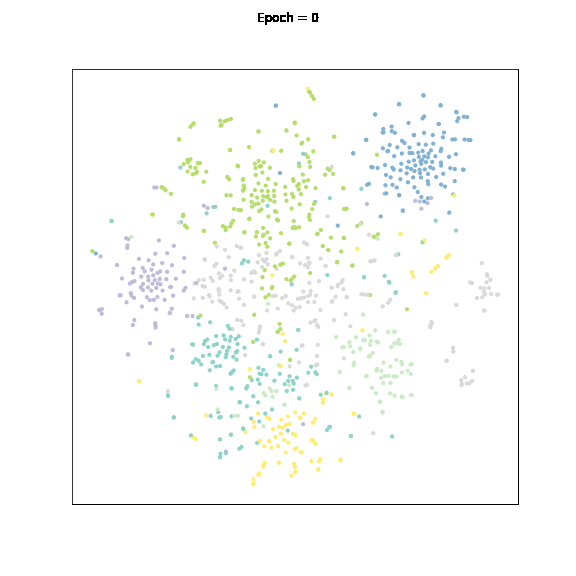

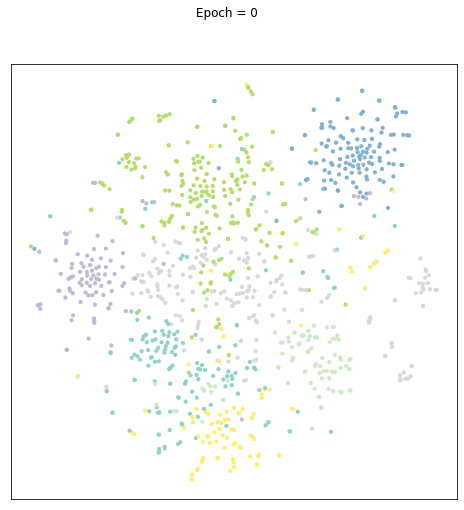

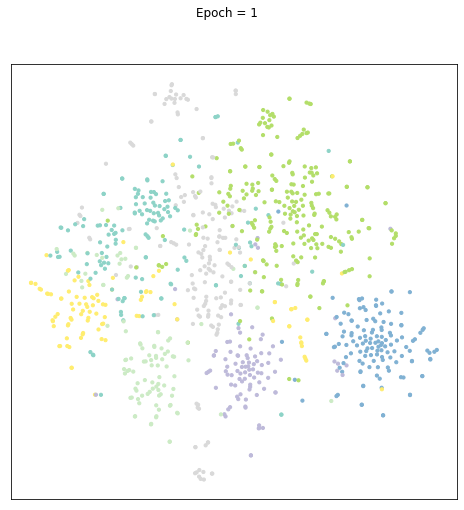

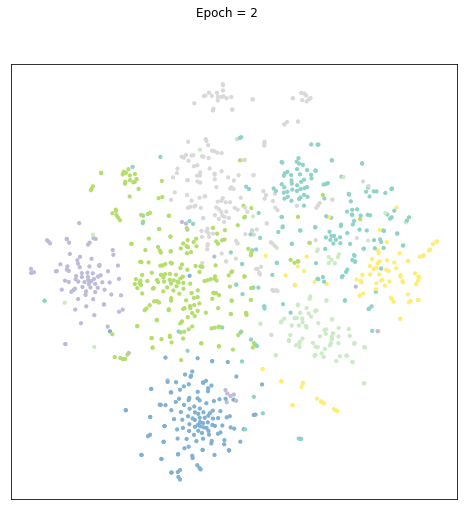

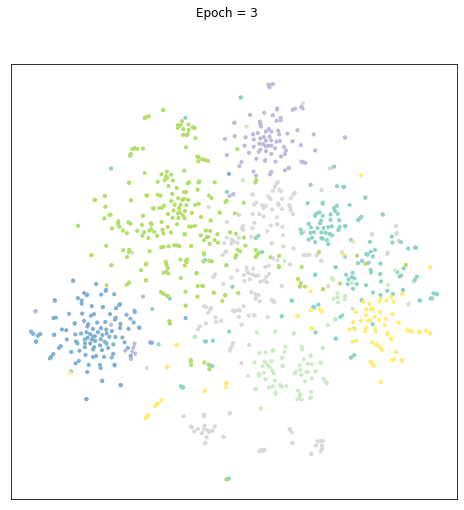

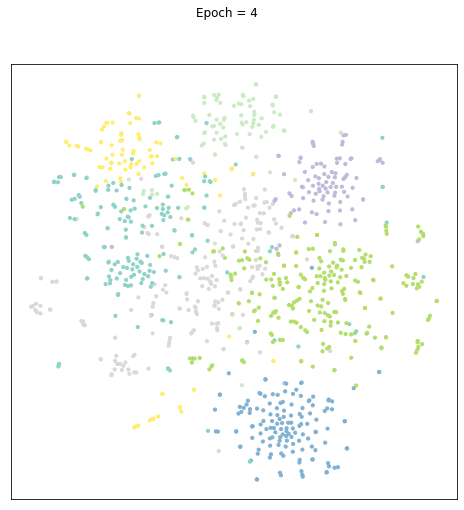

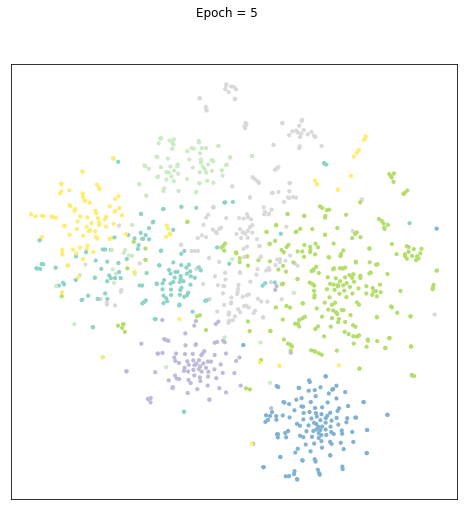

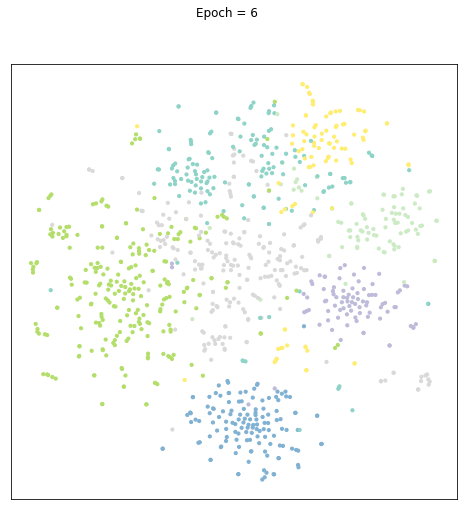

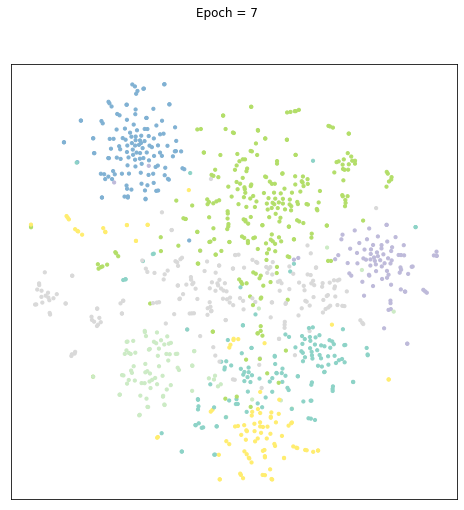

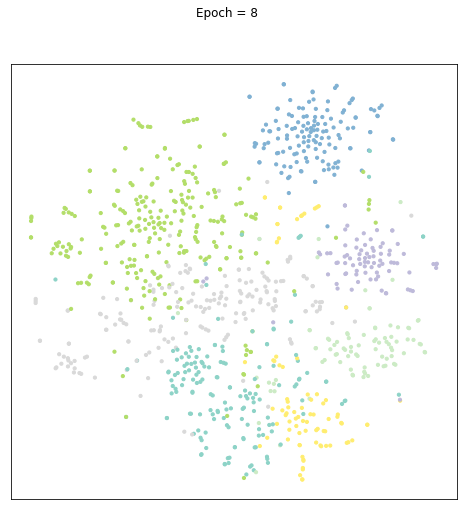

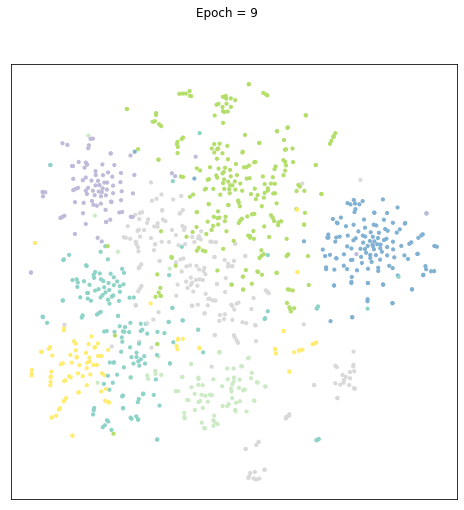

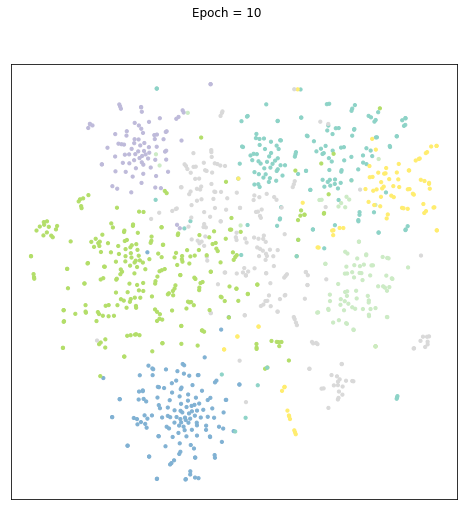

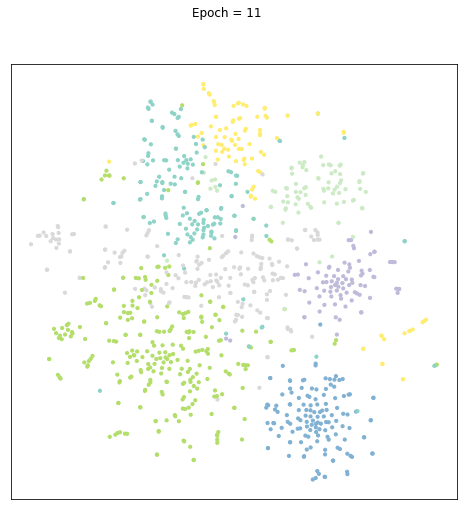

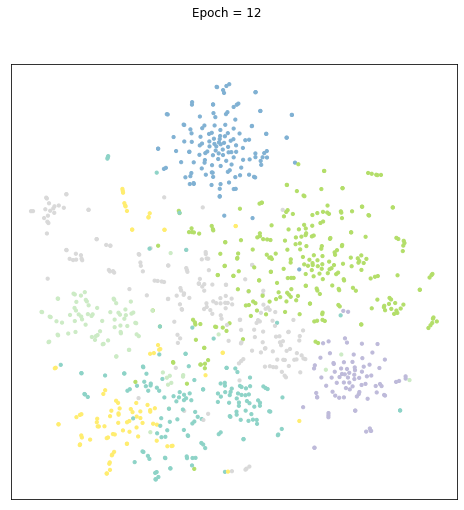

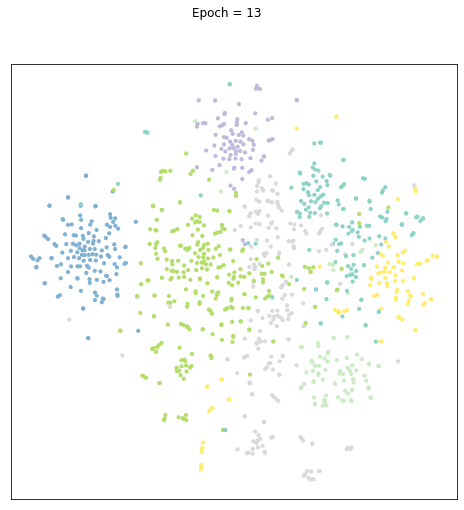

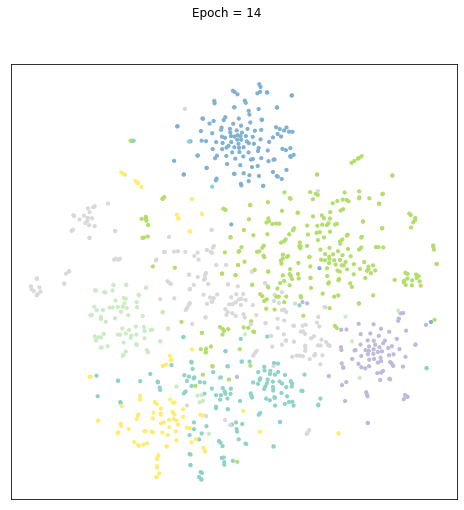

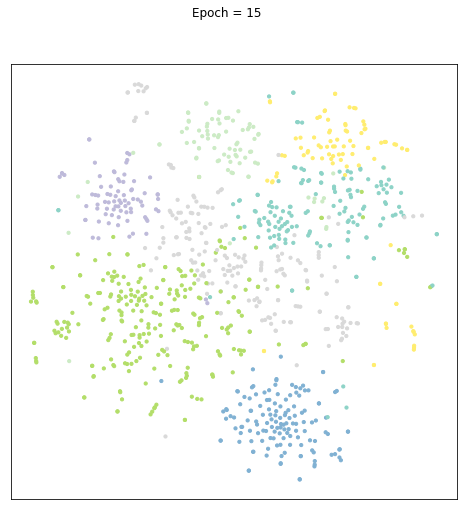

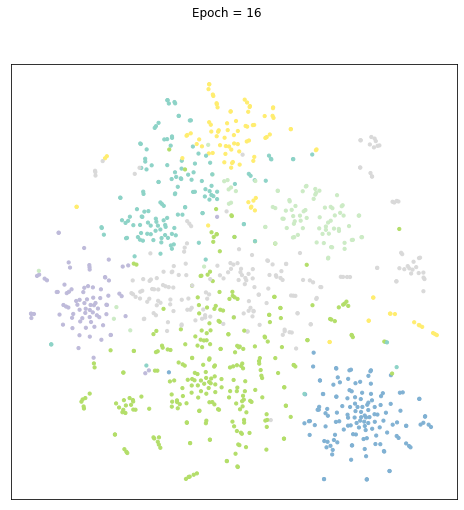

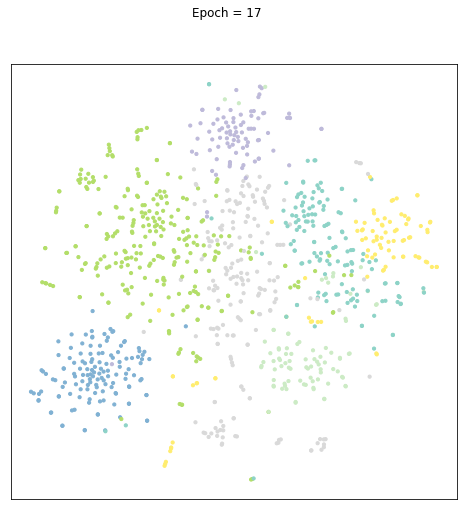

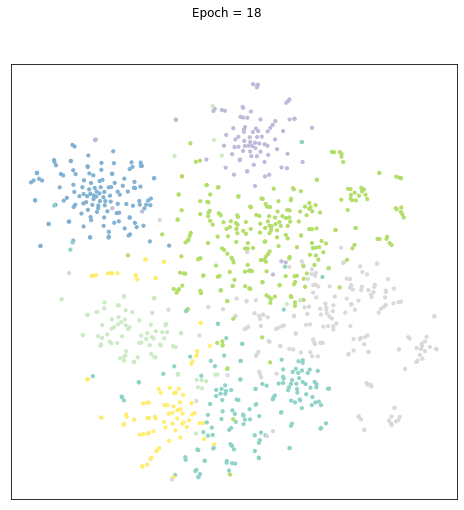

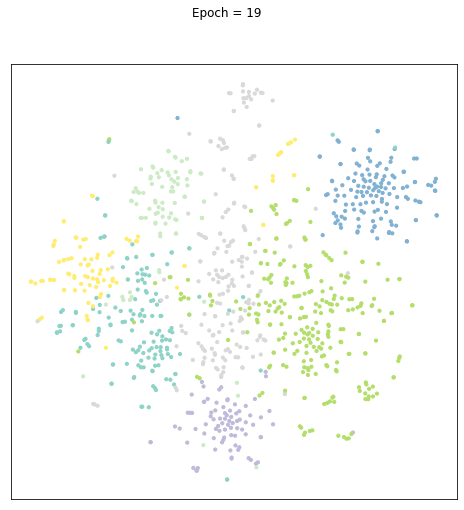

In [4]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='PyTorch GraphS GAN')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--epochs', type=int, default=20, metavar='N',
                        help='number of epochs to train (default: 20)')
    parser.add_argument('--lr', type=float, default=0.003, metavar='LR',
                        help='learning rate (default: 0.003)')
    parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                        help='SGD momentum (default: 0.5)')
    parser.add_argument('--cuda', action='store_true', default=False,
                        help='CUDA training')
    parser.add_argument('--seed', type=int, default=2, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=100, metavar='N',
                        help='how many batches to wait before logging training status')
    parser.add_argument('--eval-interval', type=int, default=1, metavar='N',
                        help='how many batches to wait before evaling training status')
    parser.add_argument('--unlabel-weight', type=float, default=0.5, metavar='N',
                        help='scale factor between labeled and unlabeled data')
    parser.add_argument('--logdir', type=str, default='./logfile', metavar='LOG_PATH', help='logfile path, tensorboard format')
    parser.add_argument('--savedir', type=str, default='./models', metavar='SAVE_PATH', help = 'saving path, pickle format')
    args, unknown = parser.parse_known_args()
    args.cuda=True
    args.cuda = args.cuda and torch.cuda.is_available()
    np.random.seed(args.seed)
    random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.cuda:
        torch.cuda.manual_seed(args.seed)
    with open('cora.dataset', 'rb') as fdata:
        dataset = pickle.load(fdata, encoding='latin1')
    gan = GraphSGAN(Generator(200, dataset.k + dataset.d), Discriminator(dataset.k + dataset.d, dataset.m), dataset, args)
    gan.train()
        